In [1]:
"""
Code written by Dautrevaux Cyprien
02/13/2024
"""

'\nCode written by Dautrevaux Cyprien\n02/13/2024\n'

In [2]:
# -----------------------
# Libraries importation :
# -----------------------

import jax
import jax.numpy as jnp
from jax import random
from jax.lib import xla_bridge
import numpy as np
import matplotlib.pyplot as plt
import arviz as ar
import numpyro as pyro
from numpyro.infer import NUTS, MCMC, Predictive
import numpyro.distributions as dist
import seaborn as sns
import os
import tqdm

# Based on Murphyk github
os.environ["XLA_FLAGS"] = "--xla_force_host_platform_device_count=8"
jax.config.update("jax_enable_x64", True)
jax.config.update("jax_platform_name", "cpu")
print(f"Cores:", jax.local_device_count())
print(f"Jax runs on: ", xla_bridge.get_backend().platform)

# -----------------------
# My module importation
# -----------------------

from OU_model import OU, theta_ou
from vbjax.loops import make_sde
from vbjax import randn

Cores: 8
Jax runs on:  cpu
c[vbjax] ███▒▒▒▒▒▒▒ loading
c[vbjax] XLA_FLAGS already set

c[vbjax] ò_ô shtns is not available
c[vbjax] ᕕ(ᐛ)ᕗ ready


In [3]:
# Simulation parameters definition
# -------------------------

key = random.PRNGKey(0) # Pseudo random number generator

nbr_regions = 5
dur = 30
dt = 0.01
time = jnp.arange(0, dur, dt)
x_init = jnp.zeros(nbr_regions, dtype=complex) 
ts = randn(int(dur/dt),*x_init.shape, key=key)

# -------------------------
# Connectivity and corr matrix
# -------------------------
j_ou = np.random.rand(nbr_regions**2).reshape(nbr_regions, nbr_regions)* 0.3
j_ou[np.diag_indices_from(j_ou)] = -0.8

corr = np.random.rand(nbr_regions**2).reshape(nbr_regions, nbr_regions)
corr[np.diag_indices_from(corr)] = 1

theta_true = theta_ou(
    J_OU = j_ou,
    corr_OU = corr
)


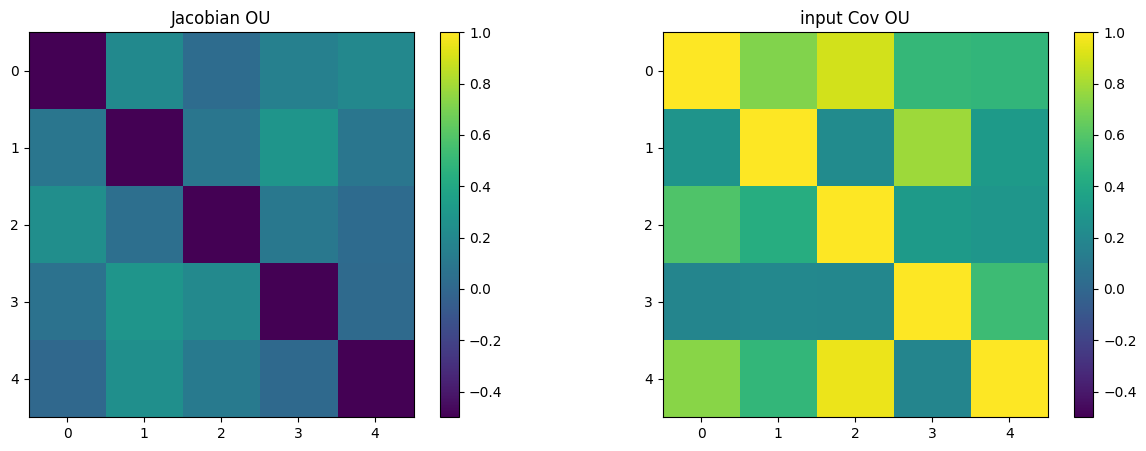

In [4]:
fig, ax  = plt.subplots(1,2, figsize = (15,5))
Title = ["Jacobian OU", "input Cov OU"]
for i, param in enumerate(theta_true):
    mat = ax[i].imshow(param, vmin = -0.5, vmax = 1)
    ax[i].set_title(Title[i])
    fig.colorbar(mat, ax=ax[i])
plt.show()    

In [14]:
# Numerical stochastic differential equations integration using vbjax librairy 

_, loops = make_sde(dt, OU.drift_OU, OU.diffusion_OU)
result_model = loops(x_init, ts, theta_true)

# Observation to match
Data = jnp.real(jnp.corrcoef(result_model.T))

/opt/anaconda3/envs/Myenv/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/Myenv/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


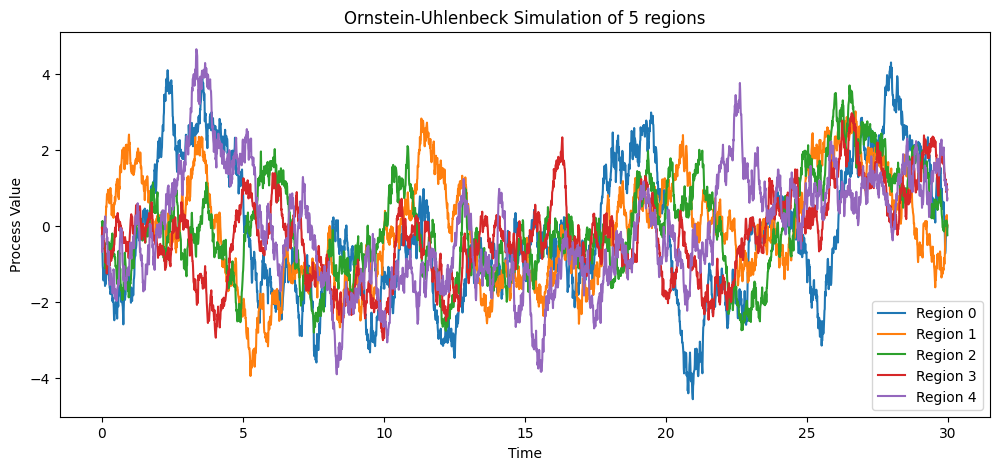

In [6]:
# Graphical representation
# -------------------------

fig, ax = plt.subplots(1,1,figsize = (12,5))
for i in range(nbr_regions):
    ax.plot(time, result_model[:,i], label = f"Region {i}")
plt.xlabel('Time')
plt.ylabel('Process Value')
plt.title('Ornstein-Uhlenbeck Simulation of 5 regions')
plt.legend()
plt.show()

## Numpyro model  

In [7]:
def model(Data = None):
    # -----------------------
    # Simulation parameters
    # -----------------------
    nbr_regions = 5
    dur = 30
    dt = 0.01  
    time = jnp.arange(0, dur, dt)
    x_init = jnp.zeros(nbr_regions, dtype=float) 
    ts = jnp.zeros((int(dur/dt),*x_init.shape))

    # -----------------------
    # Parameters prior distribution
    # -----------------------
    # -- Jacobian sampling --
    min_loc = 0.2
    sigma = 0.05
    j_ou = pyro.sample("J_OU", dist.TruncatedNormal(low= 0, loc = jnp.ones((nbr_regions, nbr_regions)) * min_loc, scale = jnp.ones((nbr_regions, nbr_regions)) * sigma ))
    j_ou_sampled = pyro.deterministic("J_OU_sampled", j_ou.at[np.diag_indices_from(j_ou)].set(-0.8))

    # -- Noise sampling --
    eps = pyro.sample("eps", dist.TruncatedNormal(low = 0, high=0.5, loc=0.05, scale=0.1))
    theta_sampled = theta_ou(J_OU = j_ou_sampled, corr_OU = 1)
    
    _, loops = make_sde(dt, OU.drift_OU, 1)
    result_model = loops(x_init, ts, theta_sampled)

    corr_sampled = jnp.real(jnp.corrcoef(result_model.T))
    with pyro.plate("Obs", size = nbr_regions, dim = -1):
        pyro.sample("obs", dist.Normal(corr_sampled, eps), obs = Data)
        

In [15]:
with pyro.handlers.seed(rng_seed=1):
    trace = pyro.handlers.trace(model).get_trace()
print(pyro.util.format_shapes(trace))

Trace Shapes:      
 Param Sites:      
Sample Sites:      
    J_OU dist 5 5 |
        value 5 5 |
     eps dist     |
        value     |
    Obs plate   5 |
     obs dist 5 5 |
        value 5 5 |


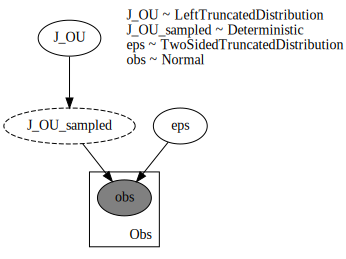

In [16]:
pyro.render_model(model, model_args=(Data,), render_distributions=True, render_params=True)

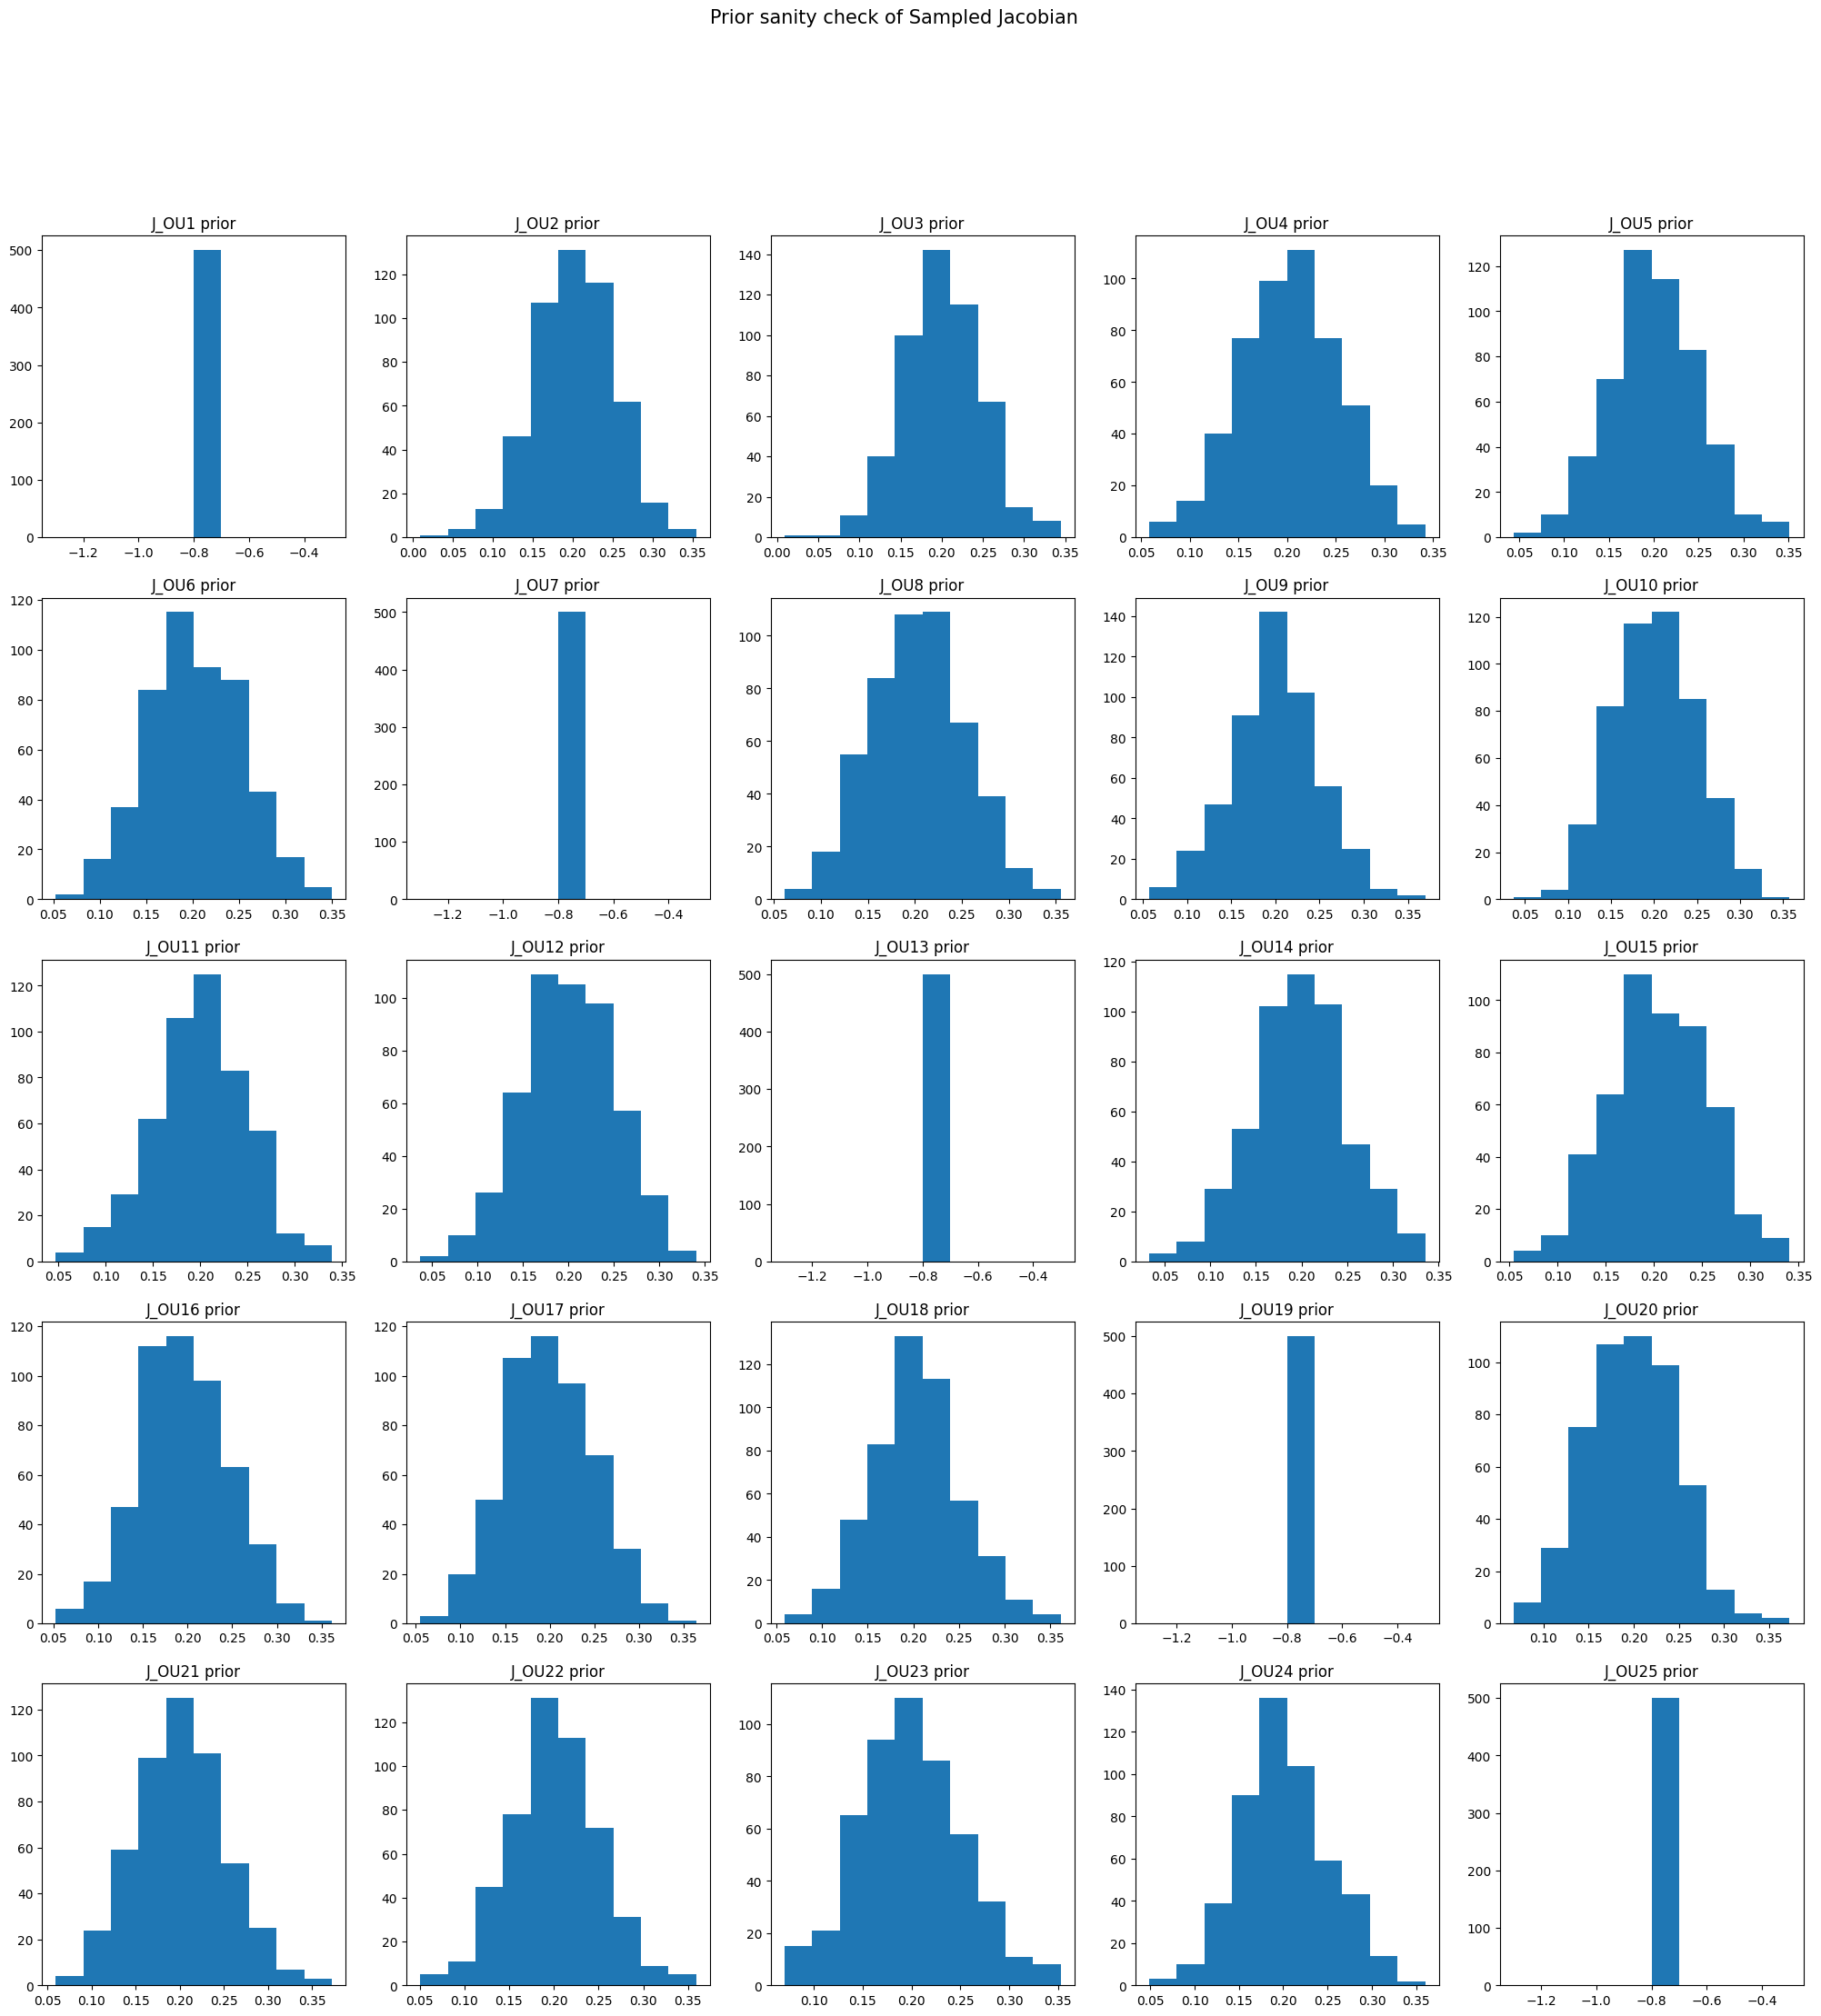

In [10]:
# Sampling from the prior distibution
# -----------------------
rng_key = random.PRNGKey(1006)
prior_predictive = Predictive(model, num_samples = 2000)
prior_prediction = prior_predictive(rng_key, Data)["J_OU_sampled"].reshape(500, -1)
nbr_parameters = len(theta_true[0].reshape(-1)) # J_OU is at position 0 

# Prior sampled distribution plot
# -----------------------
fig, ax  = plt.subplots(nbr_regions,int(nbr_parameters/nbr_regions), figsize = (25,25))
for i in range(nbr_regions):
    for j in range (int(nbr_parameters/nbr_regions)):
        ax[i, j].hist(prior_prediction[:,j + i*int(nbr_parameters/nbr_regions)], bins = 10)
        ax[i, j].set_title(f"J_OU{j + i*int(nbr_parameters/nbr_regions) + 1} prior", fontsize = 12)
fig.suptitle("Prior sanity check of Sampled Jacobian", fontsize = 15)
#plt.savefig(os.path.join(save_path,"Prior_sanity_check_DCM_EC_3columns.png"), dpi=800)
plt.show()

In [11]:
# Draw 100 samples from the sampled prior distribution of the masks
# -----------------------
n_sample = 500
parasm_random = np.zeros((n_sample, nbr_parameters))
for i in range(nbr_parameters):
    parasm_random[:,i] = np.random.choice(prior_prediction[:,i], size = n_sample)
# Perfom 100 simulations
# -----------------------
sim_data = np.zeros((int(dur/dt), nbr_regions, n_sample))
for i in range(n_sample):
    random_theta = theta_ou(
        J_OU = parasm_random[i].reshape(nbr_regions, nbr_regions),
        corr_OU = 1)
    sim_data[:,:,i] = jnp.real(loops(x_init, ts, random_theta))

/opt/anaconda3/envs/Myenv/lib/python3.9/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/opt/anaconda3/envs/Myenv/lib/python3.9/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


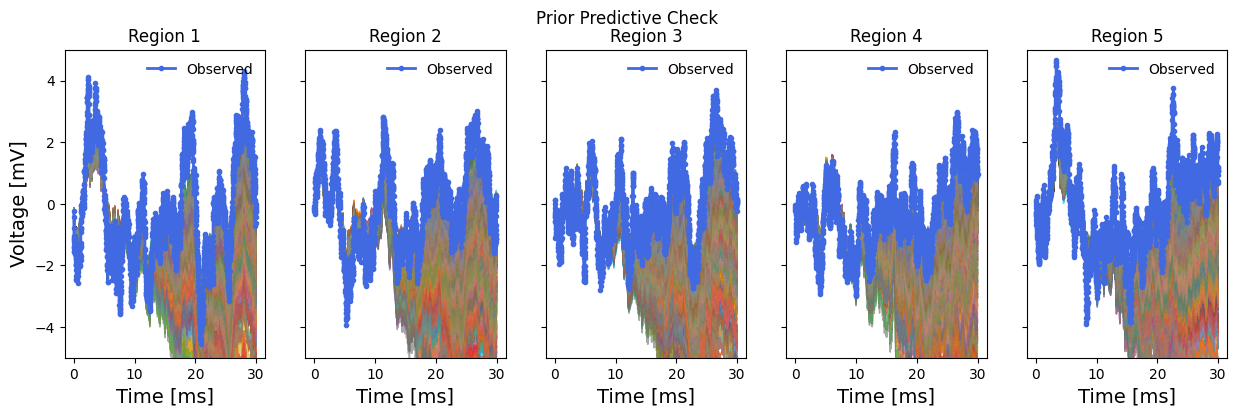

In [12]:
# -----------------------
# Prior predictive check
# -----------------------

fig, ax = plt.subplots(1, nbr_regions, figsize=(15,4), sharey=True)
for i in range(nbr_regions):
    for j in range(nbr_regions):
        ax[i].plot(time, sim_data[:,i], lw=1, alpha=0.2)
    ax[i].plot(time, result_model[:,i],'.-', color='royalblue', lw=2, label='Observed', zorder=2)
    ax[i].set_xlabel('Time [ms]', fontsize=14)
    ax[i].set_title(f"Region {i+1}")
    ax[i].legend(fontsize=10, frameon=False, loc='upper right')
    ax[i].set_ylim(-5,5)
ax[0].set_ylabel('Voltage [mV]', fontsize=14)

# Title and save
fig.suptitle('Prior Predictive Check')
#plt.savefig(os.path.join(save_path,"Prior_predictive_check_DCM_EC_3columns.png"), dpi=800)
plt.show()

In [15]:
# -----------------------
# MCMC Chains and sampling parameters
# -----------------------

num_warmup = 500
num_samples = 500
num_chains = 4

nuts_kernel_cen = NUTS(model, max_tree_depth=10, adapt_step_size=True, dense_mass=True, find_heuristic_step_size=True)

mcmc_cen = MCMC(nuts_kernel_cen, num_warmup=num_warmup, num_samples = num_samples, num_chains = num_chains, chain_method='sequential', progress_bar=True, jit_model_args=True)

mcmc_cen.run(rng_key,Data = Data, extra_fields=('potential_energy', 'num_steps', 'diverging'))

/var/folders/jk/4mnrk24x5978x4yg6mf55ss40000gn/T/ipykernel_8782/1979409040.py:13: UserWarning: Missing a plate statement for batch dimension -2 at site 'obs'. You can use `numpyro.util.format_shapes` utility to check shapes at all sites of your model.
  mcmc_cen.run(rng_key,Data = Data, extra_fields=('potential_energy', 'num_steps', 'diverging'))


ValueError: Normal distribution got invalid loc parameter.

In [ ]:
mcmc_cen.print_summary() # Remember the r_hat should be really close to 1

# Get the potential energy from the sampling, as mentionned in the extra field
potential_E = mcmc_cen.get_extra_fields()['potential_energy']
print('Expected log joint density: {:.2f}'.format(np.mean(-potential_E)))

# The log joiont probability define the probability distribution of all pairs for two random variables in the same probability space.
# This value is also defined as the log-likelihood

print("There were {} transitions that exceeded the maximum treedepth.".format(
        (mcmc_cen.get_extra_fields()["num_steps"] + 1 == 2 ** 10).sum()))